In [1]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib as mpl
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch
from torch import nn
import torch.nn.functional as F
import scipy.linalg
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! unzip /content/drive/MyDrive/images.zip

In [4]:
class AnimeFaceDataset:
    base_dir = "/content"
    img_folder = 'images'
    seed = 42
    def __init__(self, split="all", transform=transforms.ToTensor()):
        self.imgs = self._get_images()
        self.total_size = len(self.imgs)
        train_inds, test_inds = self._get_split()
        self.inds = {
            "train": train_inds,
            "test": test_inds,
            "all": np.arange(self.total_size)
        }[split]
        self.transform = transform
        
    def _get_images(self):
        return sorted([
            f for f in os.listdir(os.path.join(self.base_dir, self.img_folder))
            if f.endswith(".jpg")], key=lambda x: x.zfill(14))
    
    def _get_split(self):
        inds = np.arange(self.total_size)
        np.random.seed(self.seed)
        np.random.shuffle(inds)
        split_at = int(self.total_size * 0.9) 
        train_inds, test_inds = inds[:split_at], inds[split_at:]
        return train_inds, test_inds
    
    def __len__(self):
        return len(self.inds)
    
    def __getitem__(self, idx):
        img_path = os.path.join(
            self.base_dir, self.img_folder, self.imgs[self.inds[idx]])
        with Image.open(img_path) as im:
            return self.transform(im) if self.transform is not None else im

In [6]:
# train generative models on whole dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(0.5),  # random horizontal flipping
    transforms.ToTensor(),  # 0..255 RGB to [0, 1] (C, H, W) Tensor
    transforms.Normalize((0.5, ) * 3, (0.5, ) * 3)  # rescale to [-1, 1]
])
traindata = AnimeFaceDataset(split="train", transform=transform)
batch_size = 64
trainloader = DataLoader(
    traindata, shuffle=False, batch_size=batch_size, pin_memory=True, num_workers=0)

(-0.5, 529.5, 529.5, -0.5)

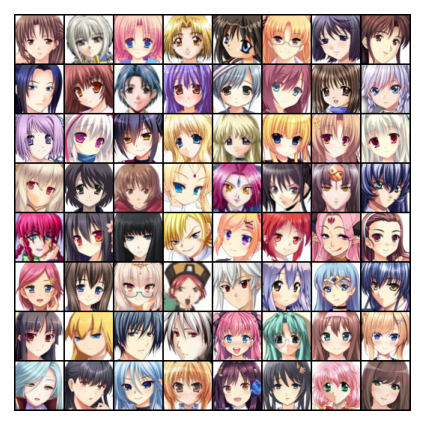

In [11]:
x = next(iter(trainloader))
img = make_grid(
    x, nrow=8,
    normalize=True, value_range=(-1, 1)).numpy().transpose(1, 2, 0)
plt.figure(figsize=(3.65, 3.65), dpi=144)
plt.imshow(img)
plt.axis("off")

In [20]:
DEFAULT_DTYPE = torch.float32

def l2_normalize(x, eps=1e-12):
    return x / (x.pow(2).sum() + eps).sqrt()


class SNLinear(nn.Module):
    dtype = DEFAULT_DTYPE

    def __init__(self, in_ft, out_ft, bias=True, use_gamma=True, pow_iter=1, lip_const=1):
        super(SNLinear, self).__init__()
        self.in_ft = in_ft
        self.out_ft = out_ft
        self.use_gamma = use_gamma
        self.pow_iter = pow_iter
        self.lip_const = lip_const
        self.weight = nn.Parameter(torch.empty((out_ft, in_ft), dtype=self.dtype))
        if bias:
            self.register_parameter(
                "bias", nn.Parameter(torch.zeros((out_ft, ), dtype=self.dtype)))
        else:
            self.register_buffer("bias", None)
        self.lip_const = lip_const
        self.register_buffer("u", torch.randn((out_ft, ), dtype=self.dtype))
        if use_gamma:
            self.register_parameter(
                "gamma", nn.Parameter(torch.ones((1, ), dtype=self.dtype)))
        else:
            self.register_paramter("gamma", None)

        # initialize the parameters
        nn.init.kaiming_normal_(self.weight, a=0., mode="fan_in")

    def _init_gamma(self):
        if self.use_gamma:
            nn.init.constant_(
                self.gamma, scipy.linalg.svd(self.weight.data, compute_uv=False)[0])

    @property
    def weight_bar(self):
        sigma, u = self.power_iteration(self.weight, self.u, self.pow_iter)
        if self.training:
            self.u = u
        weight_bar = self.lip_const * self.weight / sigma
        if self.use_gamma:
            weight_bar = self.gamma * weight_bar
        return weight_bar
    
    @staticmethod
    def power_iteration(w, u_init, num_iter=1):
        # w: (F_out, F_in)
        # u_init: (F_out, )
        u = u_init
        with torch.no_grad():
            for _ in range(num_iter - 1):
                v = l2_normalize(u @ w)
                u = l2_normalize(w @ v)
            v = l2_normalize(u @ w)
        wv = w @ v  # node allows gradient flow
        u = l2_normalize(wv.detach())
        sigma = u @ wv
        return sigma, u

    def forward(self, x):
        return F.linear(x, self.weight_bar, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_ft, self.out_ft, self.bias is not None
        )

In [21]:
class SNConv2d(nn.Module):
    dtype = DEFAULT_DTYPE

    def __init__(self, in_ch, out_ch, ksz, stride, pad, bias=True, use_gamma=True, pow_iter=1, lip_const=1):
        super(SNConv2d, self).__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.ksz = ksz
        self.stride = stride
        self.pad = pad
        self.use_gamma = use_gamma
        self.pow_iter = pow_iter
        self.lip_const = lip_const
        self.weight = nn.Parameter(
            torch.empty((out_ch, in_ch, ksz, ksz), dtype=self.dtype))
        if bias:
            self.register_parameter(
                "bias", nn.Parameter(torch.zeros((out_ch, ), dtype=self.dtype)))
        else:
            self.register_buffer("bias", None)
        self.lip_const = lip_const
        self.register_buffer("u", torch.randn((out_ch, ), dtype=self.dtype))
        if use_gamma:
            self.register_parameter(
                "gamma", nn.Parameter(torch.ones((1, ), dtype=self.dtype)))
        else:
            self.register_buffer("gamma", None)

        nn.init.kaiming_normal_(self.weight, a=0., mode="fan_in")

    def _init_gamma(self):
        if self.use_gamma:
            nn.init.constant_(
                self.gamma, scipy.linalg.svd(
                    self.weight.data.reshape(self.out_ch, -1), compute_uv=False)[0])

    def forward(self, x):
        return F.conv2d(x, self.weight_bar, self.bias, stride=self.stride, padding=self.pad)

    @property
    def weight_bar(self):
        sigma, u = self.power_iteration(self.weight, self.u, self.pow_iter)
        if self.training:
            self.u = u
        weight_bar = self.lip_const * self.weight / sigma
        if self.use_gamma:
            weight_bar = self.gamma * weight_bar
        return weight_bar
    
    @staticmethod
    def power_iteration(w, u_init, num_iter=1):
        # w: (c_out, C_in, K, K)
        # u_init: (c_out, )
        u = u_init
        with torch.no_grad():
            for _ in range(num_iter - 1):
                v = l2_normalize(torch.einsum("i,ijkl->jkl", u, w))
                u = l2_normalize(torch.einsum("ijkl,jkl->i", w, v))
            v = l2_normalize(torch.einsum("i,ijkl->jkl", u, w))
        wv = torch.einsum("ijkl,jkl->i", w, v)  # node allows gradient flow
        u = l2_normalize(wv.detach())
        sigma = (u * wv).sum()
        return sigma, u

    def extra_repr(self):
        s = ('{in_ch}, {out_ch}, kernel_size={ksz}'
             ', stride={stride}')
        if self.pad != 0:
            s += ', padding={pad}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

In [22]:
# normalization
normalize_G = nn.BatchNorm2d
activation_G = nn.ReLU


class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(self.shape)


class GenBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(GenBlock, self).__init__()
        self.bn1 = normalize_G(in_ch)
        self.act1 = activation_G(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False)
        self.bn2 = normalize_G(out_ch)
        self.act2 = activation_G(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False)
        if in_ch == out_ch:
            self.skip = nn.Identity()
        else:
            self.skip = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)

    def forward(self, x):
        out = self.conv1(self.act1(self.bn1(x)))
        out = self.conv2(self.act2(self.bn2(out)))
        out += self.skip(x)
        return out


class NetG(nn.Module):
    def __init__(self, in_ch, base_ch=64, latent_dim=128, num_blocks=[2, 2, 2, 2]):
        super(NetG, self).__init__()
        self.in_fc = nn.Sequential(
            nn.Linear(latent_dim, 16 * base_ch * 4 ** 2, bias=False), Reshape((-1, 16 * base_ch, 4, 4)))
        self.layer1 = self._make_layer(16 * base_ch, 8 * base_ch, num_blocks[0])
        self.layer2 = self._make_layer(8 * base_ch, 4 * base_ch, num_blocks[1])
        self.layer3 = self._make_layer(4 * base_ch, 2 * base_ch, num_blocks[2])
        self.layer4 = self._make_layer(2 * base_ch, base_ch, num_blocks[3])
        self.out_conv = nn.Sequential(
            normalize_G(base_ch),
            activation_G(inplace=True),
            nn.Conv2d(base_ch, in_ch, 1, 1, 0),
            nn.Tanh()
        )

        # re-initialization
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.kaiming_normal_(
                    m.weight, a=0., mode="fan_in", nonlinearity="leaky_relu")
                
        self.latent_dim = latent_dim

    @staticmethod
    def _make_layer(in_ch, out_ch, num_blocks):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            GenBlock(in_ch, out_ch),
            *[GenBlock(out_ch, out_ch) for _ in  range(num_blocks - 1)])

    def forward(self, x):
        out = self.in_fc(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return self.out_conv(out)
    
    def sample(self, n, noise=None):
        device = next(self.parameters()).device
        if noise is None:
            noise = torch.randn((n, self.latent_dim))
        return self.forward(noise.to(device))

In [23]:
# normalization
normalize_D = lambda _: nn.Identity()  # no normalization for discriminator
activation_D = nn.ReLU


class DisBlock(nn.Module):
    def __init__(self, in_ch, out_ch, downsample=False):
        super(DisBlock, self).__init__()
        self.bn1 = normalize_D(in_ch)
        self.act1 = activation_D(inplace=True)
        self.conv1 = SNConv2d(in_ch, out_ch, 3, 1 + downsample, 1)
        self.bn2 = normalize_D(out_ch)
        self.act2 = activation_D(inplace=True)
        self.conv2 = SNConv2d(out_ch, out_ch, 3, 1, 1)
        if in_ch == out_ch and not downsample:
            self.skip = nn.Identity()
        else:
            skip = [nn.AvgPool2d(2)] if downsample else []
            skip.append(SNConv2d(in_ch, out_ch, 1, 1, 0))
            self.skip = nn.Sequential(*skip)

    def forward(self, x):
        out = self.conv1(self.act1(self.bn1(x)))
        out = self.conv2(self.act2(self.bn2(out)))
        out += self.skip(x)
        return out


class NetD(nn.Module):
    def __init__(self, in_ch, base_ch=64, num_blocks=[2, 2, 2, 2]):
        super(NetD, self).__init__()
        self.in_block = DisBlock(in_ch, base_ch, downsample=True)
        self.layer1 = self._make_layer(base_ch, 2 * base_ch, num_blocks[0])
        self.layer2 = self._make_layer(2 * base_ch, 4 * base_ch, num_blocks[1])
        self.layer3 = self._make_layer(4 * base_ch, 8 * base_ch, num_blocks[2])
        self.layer4 = self._make_layer(8 * base_ch, 16 * base_ch, num_blocks[3])
        self.out_fc = nn.Sequential(
            normalize_D(16 * base_ch),
            activation_D(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
            SNLinear(16 * base_ch, 1)
        )

        # re-initialization
        for m in self.modules():
            if isinstance(m, (SNConv2d, SNLinear)):
                nn.init.kaiming_normal_(
                    m.weight, a=0., mode="fan_in", nonlinearity="leaky_relu")
                if m.use_gamma:
                    m._init_gamma()
                    
        # turn off in-place relu before the first conv layer
        self.in_block.act1 = nn.Identity()

    @staticmethod
    def _make_layer(in_ch, out_ch, num_blocks):
        return nn.Sequential(
            DisBlock(in_ch, out_ch, downsample=True),
            *[DisBlock(out_ch, out_ch) for _ in  range(num_blocks-1)])

    def forward(self, x):
        out = self.in_block(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return self.out_fc(out)

In [24]:
traindata = AnimeFaceDataset(split="all", transform=transform)
batch_size = 64

# if an error, change num_workers to 0
trainloader = DataLoader(
    traindata, shuffle=True, batch_size=batch_size, drop_last=True, pin_memory=True, num_workers=os.cpu_count())

lr = 0.0002
beta1 = 0.0
beta2 = 0.9

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_ch = 3
base_ch = 64
latent_dim = 128

netD = NetD(in_ch, base_ch, [1, 1, 1, 1])
netG = NetG(in_ch, base_ch, latent_dim, [1, 1, 1, 1])
netD.to(device)
netG.to(device)

optD = Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optG = Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

# hinge loss
loss_fn_D = lambda x, y: torch.clamp(1 - x * y, min=0).mean()
loss_fn_G = lambda x, _: x.neg().mean()

n_epochs = 50

torch.manual_seed(42)
gen_size = 64
gen_noise = torch.randn((gen_size, latent_dim))

chkpt_intv = 10
chkpt_dir = "/content/checkpoints"
if not os.path.exists(chkpt_dir):
    os.makedirs(chkpt_dir)
chkpt_path = os.path.join(chkpt_dir, "anime-sngan.pt")

img_dir = "/content/imgs"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

n_dis = 1  # number of discriminator updates per iteration
gen_batches = 2
n_gen_fake = batch_size * gen_batches   # number of fake examples for single generator update

# torch.autograd.set_detect_anomaly(True)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.benchmark = True

In [ ]:
for e in range(n_epochs):
    total_dis_loss = 0
    total_gen_loss = 0
    total_dis_cnt = 0
    total_gen_cnt = 0
    with tqdm(trainloader, desc=f"{e + 1}/{n_epochs} epochs", ncols=100) as t:
        netG.train()
        for i, x_true in enumerate(t):
            # netD step
            cnt = x_true.shape[0]
            with torch.no_grad():
                x_fake = netG.sample(cnt)
            dis_loss = loss_fn_D(
                netD(x_true.to(device)), torch.ones((cnt, 1), device=device))
            dis_loss += loss_fn_D(
                netD(x_fake), -torch.ones((cnt, 1), device=device))
            netD.zero_grad(set_to_none=True)
            dis_loss.backward()
            optD.step()
            # keep track of running statistics
            total_dis_loss += dis_loss.item() * cnt 
            total_dis_cnt += cnt
            
            # update G every n_dis minibatch = update D n_dis times before G update
            if i % n_dis == 0:  
                # netG step
                netG.zero_grad(set_to_none=True)
                for _ in range(gen_batches):
                    x_fake = netG.sample(batch_size)
                    gen_loss = loss_fn_G(
                        netD(x_fake), torch.ones((n_gen_fake, 1), device=device))
                    gen_loss.backward()
                optG.step()
                total_gen_loss += gen_loss.item() * n_gen_fake
                total_gen_cnt += n_gen_fake
        
                t.set_postfix({
                    "dis_loss": total_dis_loss / total_dis_cnt,
                    "gen_loss": total_gen_loss / total_gen_cnt
                })
            
            if i == len(trainloader) - 1:
                netG.eval()
                with torch.no_grad():
                    gen_imgs = netG.sample(gen_size, gen_noise).cpu()
                gen_imgs = make_grid(
                    gen_imgs, nrow=8, normalize=True, value_range=(-1, 1)).numpy().transpose(1, 2, 0)
                plt.imsave(os.path.join(img_dir, f"{e+1}.jpg"), gen_imgs)
                if (e + 1) % chkpt_intv == 0:
                    torch.save(
                        {
                            "netD": netD.state_dict(),
                            "netG": netG.state_dict(),
                            "optD": optD.state_dict(),
                            "optG": optG.state_dict(),
                            "epoch": e + 1
                        }, chkpt_path)